# Méthodes de défense

Ce projet vise à tester et comparer plusieurs attaques "adversarial" contre le réseau de neurones résiduels WideResNet50_2, entraîné sur le jeu de données CIFAR10.
Afin de rendre le modèle plus robuste, un entraînement adversarial sera mis en place. 

Les courbes qui reflètent les résultats de nos modèles ont été enregistrés dans le fichier "saved_data.npy".

In [2]:
! pip install torchattacks

import numpy as np
with open('./saved_data.npy', 'rb') as f:
    epsilons_ = np.load(f)

    # Robustesse du modèle sans entraîenemnt face à PGD-10
    accuracy_naturel_wide_Resnet50_2 = np.load(f)

    # Robustesse du modèle entraîné avec des images attaquées face à PGD-10
    accuracy_adv_training_wide_Resnet50_2 = np.load(f)

    # Robustesse du modèle entraîné avec des images attaquées face à PGD-10 + un bruit gaussien (centré en 8/255)
    accuracy_adv_training_noise_wide_Resnet50_2 = np.load(f)

    # Robustesse du modèle avec autoencodeur (DDSA) face à PGD-10
    accuracies_autoencodeur_wide_Resnet50_2 = np.load(f)

    # Robustesse du modèle avec autoencodeur (DDSA) face à PGD-10 + un bruit gaussien (centré en 8/255)
    accuracies_autoencodeur_noise_wide_Resnet50_2 = np.load(f)

Nous allons commencer par importer le jeu de données CIFAR10. Il y a un total de 6000 images de 10 classes différentes. Toutes les images sont au format 32×32.

In [3]:
%load_ext autoreload
%autoreload 2

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt

! pip install albumentations
from utils import plot_augmentation
import albumentations as A
from  albumentations.pytorch.transforms import ToTensorV2

transform = transforms.Compose(
    [transforms.ToTensor()]
)

batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

/home/imaginat0r/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/imaginat0r/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 102 kB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 47.8 MB 266 kB/s  eta 0:00:01      | 18.0 MB 15.8 MB/s eta 0:00:02
Files already downloaded and verified
Files already downloaded and verified


In [4]:
print("Taille du jeu d'entrainement :" ,len(trainloader.dataset))
print("Taille du jeu de test :" ,len(testloader.dataset))
print("Dimension d'une image (format RGB) :" ,trainloader.dataset[0][0].shape)

Taille du jeu d'entrainement : 50000
Taille du jeu de test : 10000
Dimension d'une image (format RGB) : torch.Size([3, 32, 32])


In [5]:
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA Available:  False


## Définition du modèle (WideResnet50_2)

In [17]:
from models import create_wideResnet50_2, create_Resnet50_2

# resnet20 = create_Resnet50_2(device)
wide_resnet50_2 = create_wideResnet50_2(device)


print(wide_resnet50_2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

## Attaques

Une attaque adversarial est une perturbation (bruit) spécifique ajoutée à une image afin de tromper le modèle. L'attaque est conçue pour être très peu perceptible à l'oeil nu sur l'image.

Nous allons principalement utilisé les attaques :
- Fast Gradient Sign Method (FGSM)
- Basic Iteractive Method (BIM)
- Projected Gradient Descent (PGD)
- Deep Fool
- Carlini-Wagner (C&W)


In [6]:
from attacks import PGD_linf,fgsm_attack,BIM,deepfool

## Entraînement classique

Nous allons dans un premier temps entraîner le modèle WideResNet-50-2 sans attaque. L'impact des attaques sur les performances du modèle pourra ainsi être mesuré en observant l'exactitude du réseau en fonction du budget de perturbation autorisé.

In [2]:
from training import training

params = {"epochs" : 10,
    "epsilon" : 8/255, 
    "n_iter" : 10,
    "alpha":  0.007, 
    "num_exemples":5,
    "use_FGSM" : True,
    "use_autoencoder" : False,

    "noise_factor" : 8/255,
    "params_model":{
        "lr" : 0.00001 
    }
}

test_accuracies, test_losses = training(wide_resnet50_2,device,trainloader,testloader, params)

Le modèle (WideResNet50_2) atteint une exactitude de 87.1% après un entraînement classique. Les caractéristiques de 
l'entraînement sont :
- Nombre de batch : 32
- Nombre d'epochs : 64
- Stratégie de "cosine annealing with restart" pour le taux d'apprentissage

In [20]:
from training import test_model

loss_fn = nn.CrossEntropyLoss()
test_model(testloader,device,wide_resnet50_2,loss_fn)

Test Error: 
 Accuracy: 87.1% 



## Effet de l'attaque sur les performances du modèle entraîné

Pour mesurer les performances de l'attaque PGD et la robustesse de notre modèle, nous allons appliquer plusieurs attaques PGD-10 (10 itérations) avec un budget de perturbation (epsilon) croissant :

Epsilon : 0.0


100%|██████████| 79/79 [00:00<00:00, 912809.96it/s]


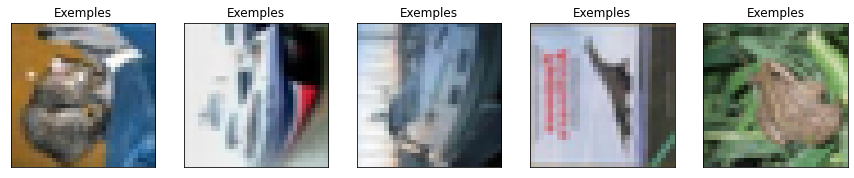

Accuracy: 87.812% 

Epsilon : 0.006604747162022704


100%|██████████| 79/79 [00:00<00:00, 157261.52it/s]


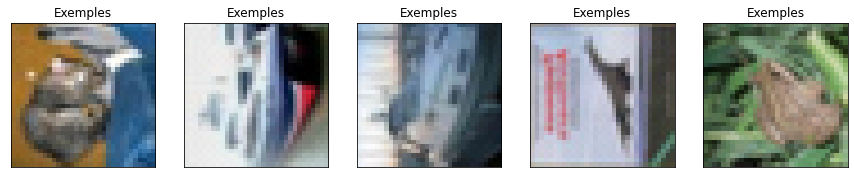

Accuracy: 36.981% 

Epsilon : 0.013209494324045407


100%|██████████| 79/79 [00:00<00:00, 336737.82it/s]


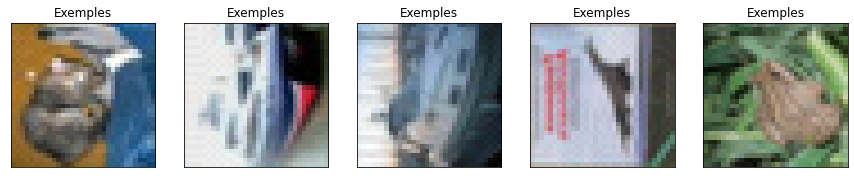

Accuracy: 7.13% 

Epsilon : 0.019814241486068113


100%|██████████| 79/79 [00:00<00:00, 277280.35it/s]


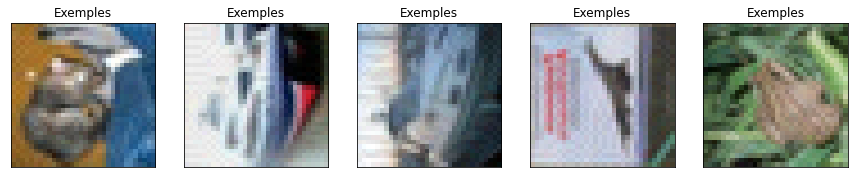

Accuracy: 2.908% 

Epsilon : 0.026418988648090815


100%|██████████| 79/79 [00:00<00:00, 583362.70it/s]


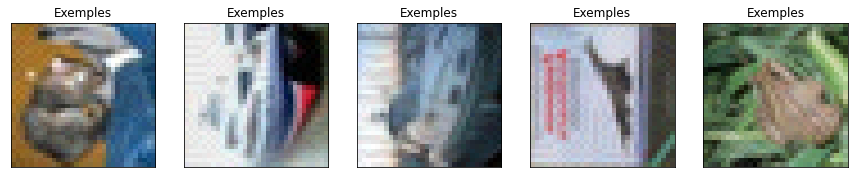

Accuracy: 2.1% 

Epsilon : 0.033023735810113516


100%|██████████| 79/79 [00:00<00:00, 291938.34it/s]


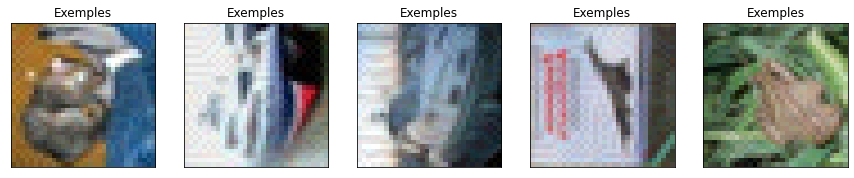

Accuracy: 1.796% 

Epsilon : 0.039628482972136225


100%|██████████| 79/79 [00:00<00:00, 242569.56it/s]


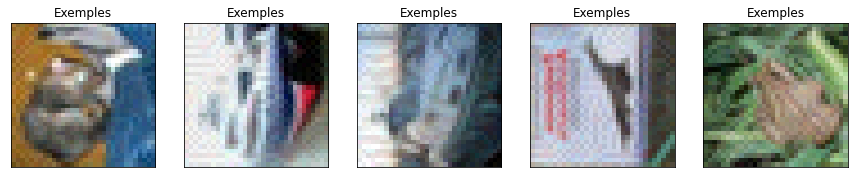

Accuracy: 1.754% 

Epsilon : 0.04623323013415893


100%|██████████| 79/79 [00:00<00:00, 298513.53it/s]


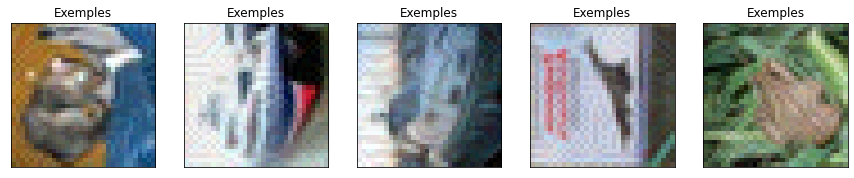

Accuracy: 1.638% 

Epsilon : 0.05283797729618163


100%|██████████| 79/79 [00:00<00:00, 267433.43it/s]


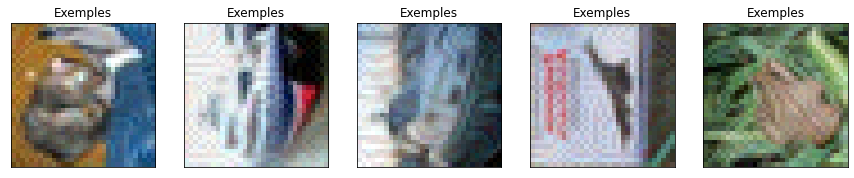

Accuracy: 1.648% 

Epsilon : 0.05944272445820433


100%|██████████| 79/79 [00:00<00:00, 349157.02it/s]


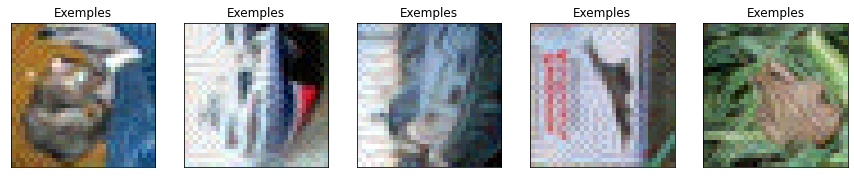

Accuracy: 1.564% 

Epsilon : 0.06604747162022703


100%|██████████| 79/79 [00:00<00:00, 270932.15it/s]


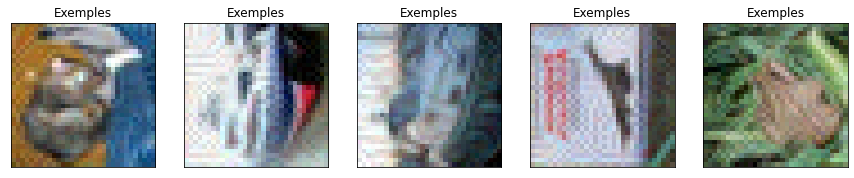

Accuracy: 1.575% 

Epsilon : 0.07265221878224974


100%|██████████| 79/79 [00:00<00:00, 126373.00it/s]


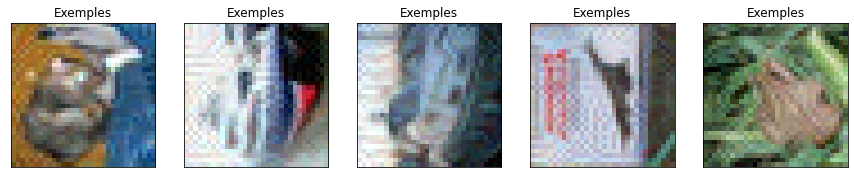

Accuracy: 1.523% 

Epsilon : 0.07925696594427245


100%|██████████| 79/79 [00:00<00:00, 277512.58it/s]


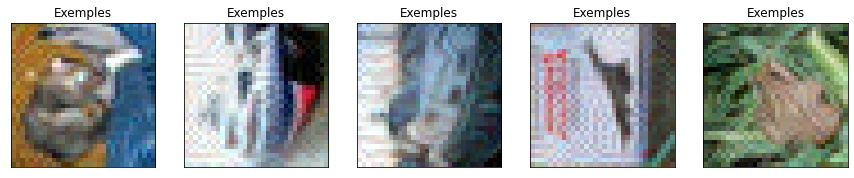

Accuracy: 1.48% 

Epsilon : 0.08586171310629515


100%|██████████| 79/79 [00:00<00:00, 355144.71it/s]


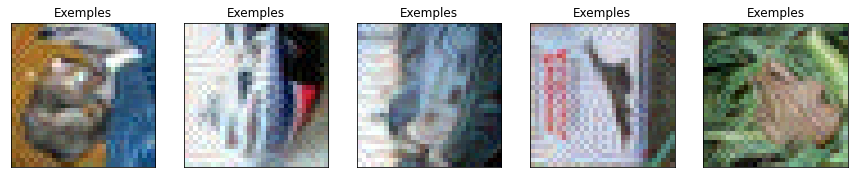

Accuracy: 1.48% 

Epsilon : 0.09246646026831785


100%|██████████| 79/79 [00:00<00:00, 278445.39it/s]


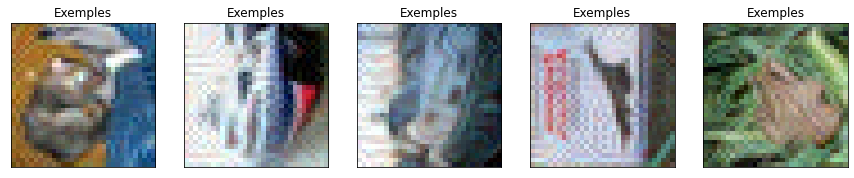

Accuracy: 1.46% 

Epsilon : 0.09907120743034055


100%|██████████| 79/79 [00:00<00:00, 566410.28it/s]


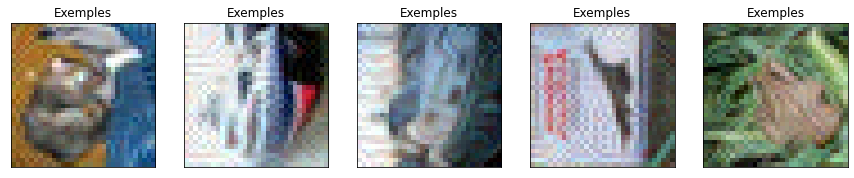

Accuracy: 1.449% 

Epsilon : 0.10567595459236326


100%|██████████| 79/79 [00:00<00:00, 488716.84it/s]


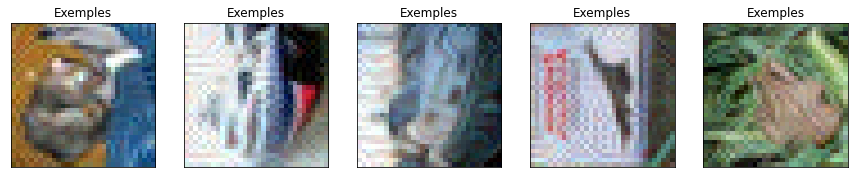

Accuracy: 1.438% 

Epsilon : 0.11228070175438597


100%|██████████| 79/79 [00:00<00:00, 209185.62it/s]


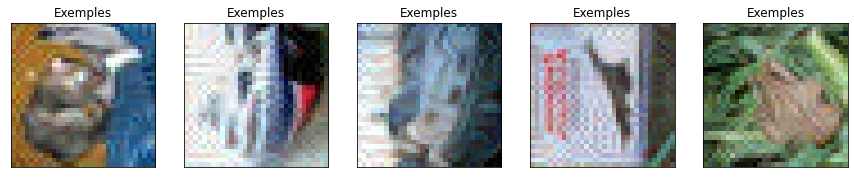

Accuracy: 1.418% 

Epsilon : 0.11888544891640866


100%|██████████| 79/79 [00:00<00:00, 56161.02it/s]


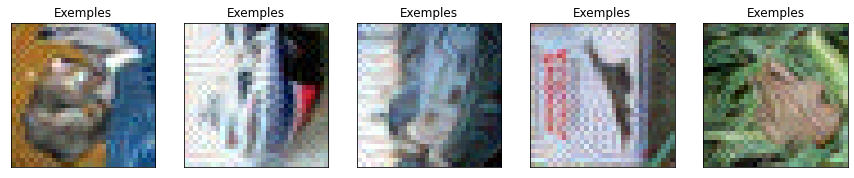

Accuracy: 1.418% 

Epsilon : 0.12549019607843137


100%|██████████| 79/79 [00:00<00:00, 28596.70it/s]


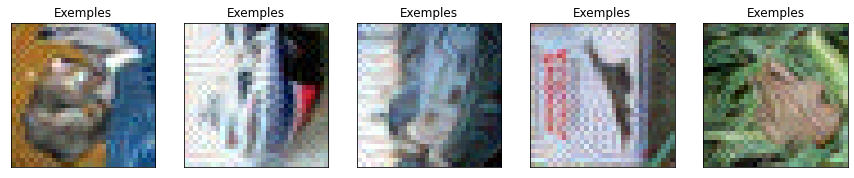

Accuracy: 1.418% 



In [12]:
from evaluate import pgd_attack_effect_on_accuracy

params = {
    "epsilons" : np.linspace(0,32/255,20),
    "n_iter" : 10,
    "alpha":  3/255, # alpha infini
    "num_exemples": 5,
    "attack" : "PGD",
    "noise": None,
    "denoiser" :None

}

epsilons_adv_w_noise, accuracies_adv_w_noise = pgd_attack_effect_on_accuracy(wide_resnet50_2,device,testloader,params)

Le budget de perturbation (epsilon) sur l'image est donnée suivant la norme infinie. On remarque les perturbations commencent à être visibles à partir d'un certain budget.

(0.0, 0.05)

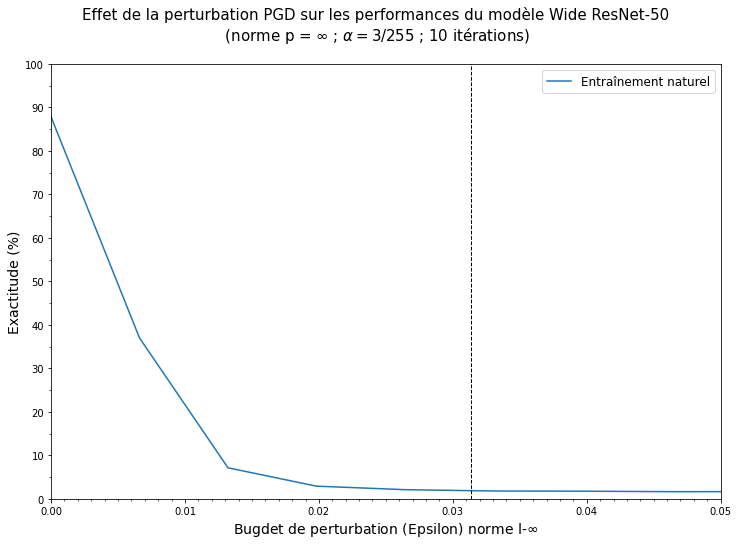

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
X_Y_LABEL_SIZE = 14
TITLE_SIZE = 15

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epsilons_,accuracy_naturel_wide_Resnet50_2)
plt.xlabel(r"Bugdet de perturbation (Epsilon) norme l-$\infty$",fontsize=X_Y_LABEL_SIZE)
plt.ylabel("Exactitude (%)",fontsize=X_Y_LABEL_SIZE)
fig.suptitle('Effet de la perturbation PGD sur les performances du modèle Wide ResNet-50\n'+r' (norme p = $\infty$ ; $\alpha = 3/255$ ; 10 itérations)', fontsize=TITLE_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(0.01))
ax.xaxis.set_minor_locator(MultipleLocator(0.001))

ax.axvline(x=8/255, color='k',lw=1,linestyle="--")

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(["Entraînement naturel"],loc=1, prop={'size': 12})

plt.ylim([0,100])
plt.xlim([0,0.05])

On remarque que pour epsilon = 8/255 (ligne verticale en pointillés), l'exactitude du modèle tombe à 2,1 %, alors que les perturbations sur l'image ne sont pas perceptibles.

# Stratégie de défense I : Entraînement adversarial

Notre première stratégie de défense consiste à effectuer un entraînement adversarial du modèle WideResNet50_2. L'objectif est de recommencer l'entrainement mais cette fois-ci en attaquant les images avant de les fournir au modèle avec le bon label.

A chaque batch, un type de perturbation est tiré aléatoirement et est appliqué au batch avant d'être donné au modèle. Les perturbations sont choisis parmi les méthodes suivantes :
- Attaque FGSM  (budget : 8/255 ; norme infinie)
- PGD (budget : 8/255 ; norme infinie)
- Bruit gaussien, Random Crop, Random Flip, Bruit Speckle, Bruit Salt
- DeepFool (budget : 8/255 ; norme infinie)

In [14]:
from training import adversarial_training

params = {"epochs" : 100,
    "epsilon" : 8/255, #epsilon infini
    "n_iter" : 10,
    "alpha": 3/255, # alpha infini

    "deepfool_steps" : 10,
    "num_exemples":5,

    "params_model":{
        "lr" : 0.001 
    }
}

wide_resnet50_2_adv = copy.copy(wide_resnet50_2)
adversarial_training(wide_resnet50_2_adv,device,trainloader,testloader, params)

Evaluation de la robustesse du modèle entraîné avec des exemples "adversarial" face à une attaque PGD-10 :

Epsilon : 0.0


100%|██████████| 79/79 [00:00<00:00, 720326.12it/s]


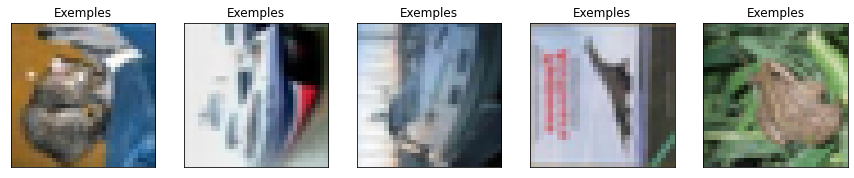

Accuracy: 72.22% 

Epsilon : 0.006604747162022704


100%|██████████| 79/79 [00:00<00:00, 642151.19it/s]


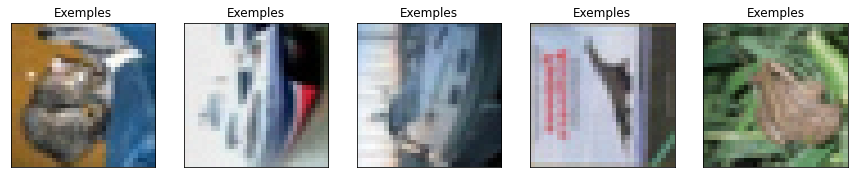

Accuracy: 69.6438947368421% 

Epsilon : 0.013209494324045407


100%|██████████| 79/79 [00:00<00:00, 594883.33it/s]


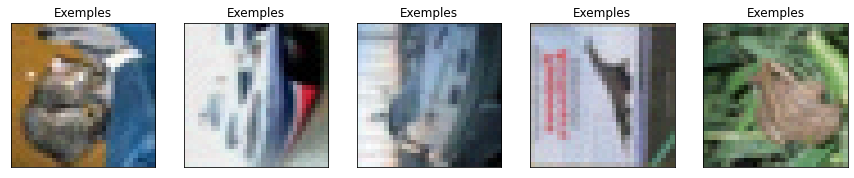

Accuracy: 66.42957894736843% 

Epsilon : 0.019814241486068113


100%|██████████| 79/79 [00:00<00:00, 527627.41it/s]


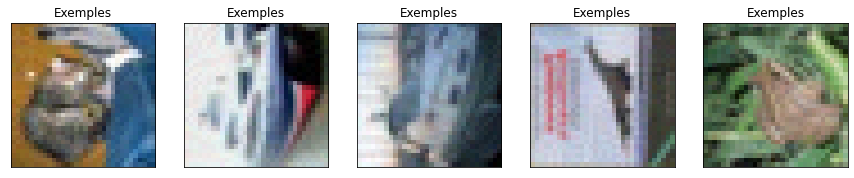

Accuracy: 62.228947368421046% 

Epsilon : 0.026418988648090815


100%|██████████| 79/79 [00:00<00:00, 619345.82it/s]


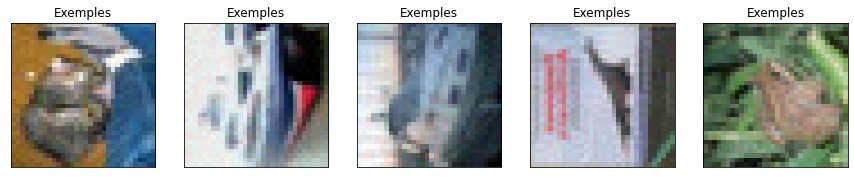

Accuracy: 57.030631578947364% 

Epsilon : 0.033023735810113516


100%|██████████| 79/79 [00:00<00:00, 633556.44it/s]


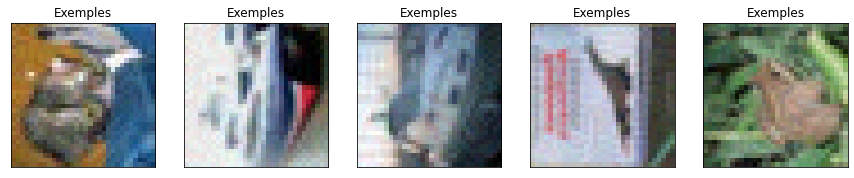

Accuracy: 51.10842105263158% 

Epsilon : 0.039628482972136225


100%|██████████| 79/79 [00:00<00:00, 401636.38it/s]


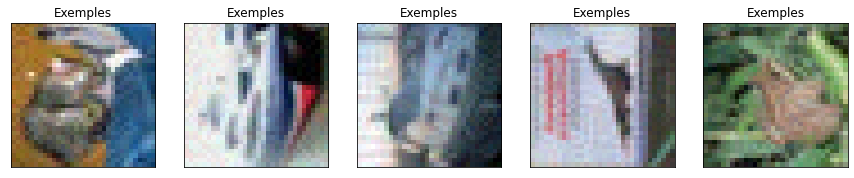

Accuracy: 44.89431578947367% 

Epsilon : 0.04623323013415893


100%|██████████| 79/79 [00:00<00:00, 478138.55it/s]


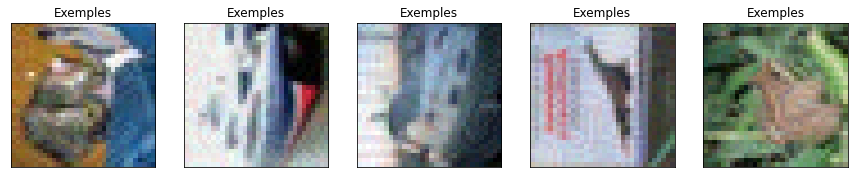

Accuracy: 39.15284210526316% 

Epsilon : 0.05283797729618163


100%|██████████| 79/79 [00:00<00:00, 463426.60it/s]


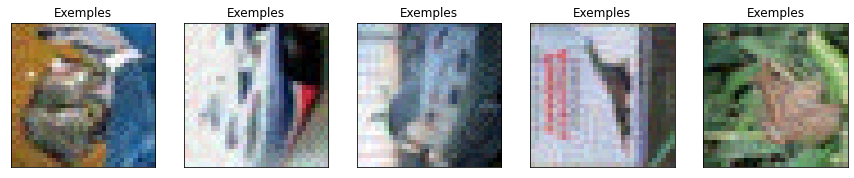

Accuracy: 33.421052631578945% 

Epsilon : 0.05944272445820433


100%|██████████| 79/79 [00:00<00:00, 394934.46it/s]


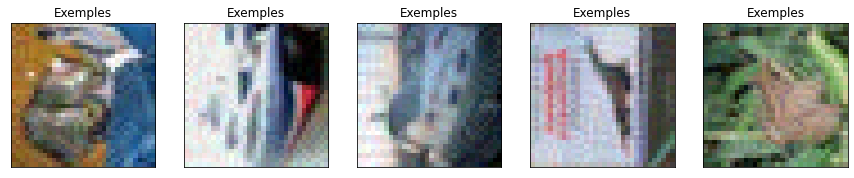

Accuracy: 27.785789473684215% 

Epsilon : 0.06604747162022703


100%|██████████| 79/79 [00:00<00:00, 434272.63it/s]


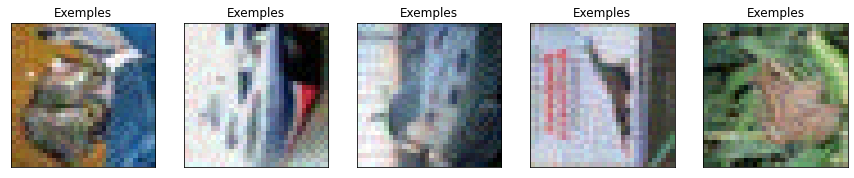

Accuracy: 23.660526315789475% 

Epsilon : 0.07265221878224974


100%|██████████| 79/79 [00:00<00:00, 391204.27it/s]


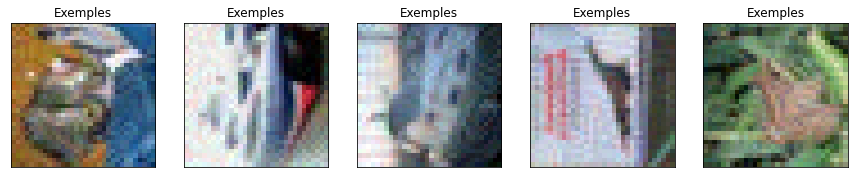

Accuracy: 19.898947368421055% 

Epsilon : 0.07925696594427245


100%|██████████| 79/79 [00:00<00:00, 490888.91it/s]


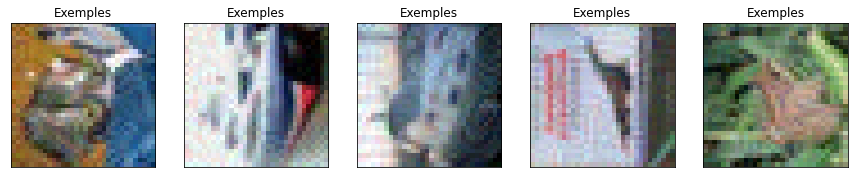

Accuracy: 16.75357894736842% 

Epsilon : 0.08586171310629515


100%|██████████| 79/79 [00:00<00:00, 475394.57it/s]


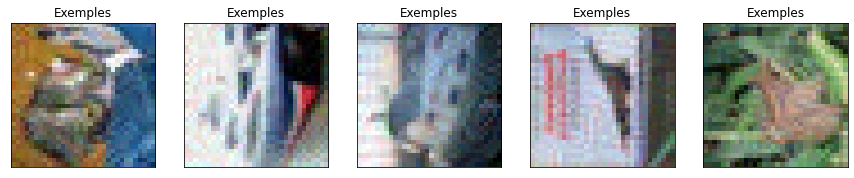

Accuracy: 14.20484210526316% 

Epsilon : 0.09246646026831785


100%|██████████| 79/79 [00:00<00:00, 432571.82it/s]


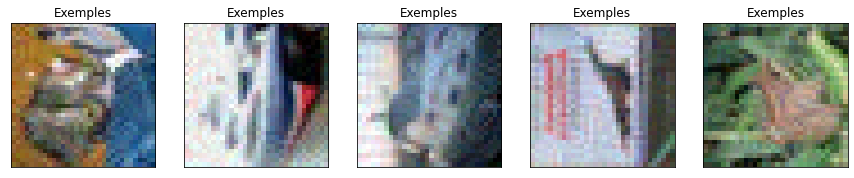

Accuracy: 11.905157894736842% 

Epsilon : 0.09907120743034055


100%|██████████| 79/79 [00:00<00:00, 400665.07it/s]


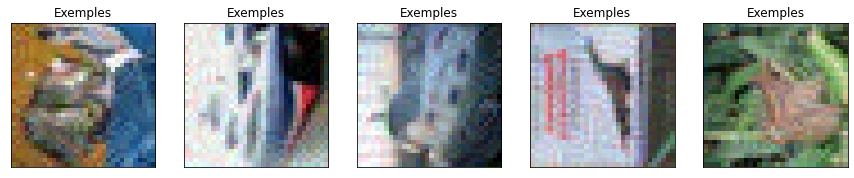

Accuracy: 10.148421052631578% 

Epsilon : 0.10567595459236326


100%|██████████| 79/79 [00:00<00:00, 166256.91it/s]


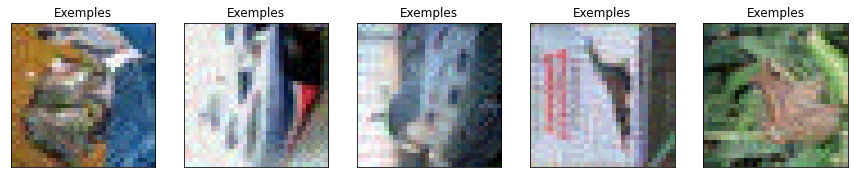

Accuracy: 8.435368421052631% 

Epsilon : 0.11228070175438597


100%|██████████| 79/79 [00:00<00:00, 474034.36it/s]


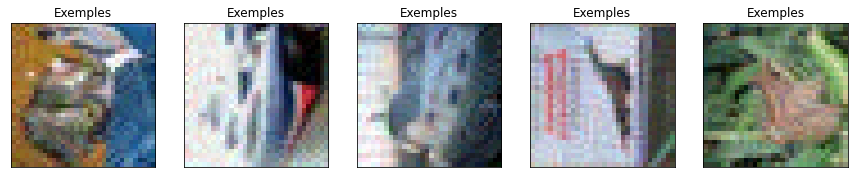

Accuracy: 7.25778947368421% 

Epsilon : 0.11888544891640866


100%|██████████| 79/79 [00:00<00:00, 413154.63it/s]


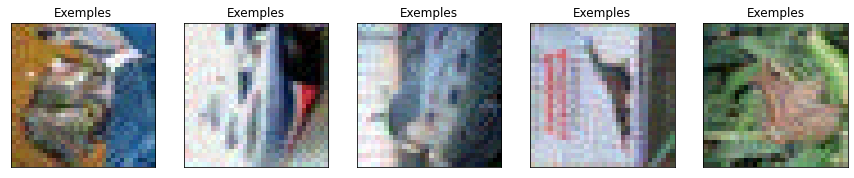

Accuracy: 6.6272631578947365% 

Epsilon : 0.12549019607843137


100%|██████████| 79/79 [00:00<00:00, 369810.29it/s]


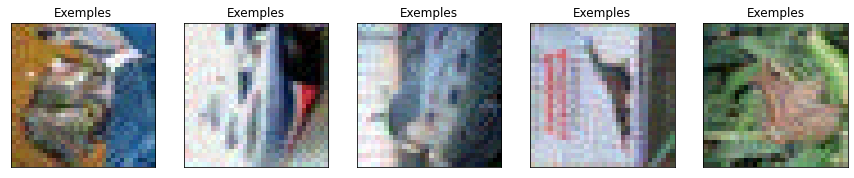

Accuracy: 6.786% 



In [43]:
params = {
    "epsilons" : np.linspace(0,32/255,20),
    "n_iter" : 10,
    "alpha":  3/255, # alpha infini
    "num_exemples": 5,
    "attack" : "PGD",
    "noise": None,
    "denoiser" :None

}

epsilons_adv_w_noise, accuracies_adv_w_noise = pgd_attack_effect_on_accuracy(wide_resnet50_2_adv,device,testloader,params)

Impact de l'attque PGD-100 (100 itérations, epsilon = 8/255) sur le modèle entrainé sans exemples "adversarial"

In [23]:
params = {
    "epsilons" : np.linspace(0,32/255,20),
    "n_iter" : 10,
    "alpha":  3/255, # alpha infini
    "num_exemples": 5,
    "attack" : "PGD",
    "noise": None,
    "denoiser" :None

}

test_pgd(wide_resnet50_2,device,testloader,
         steps=100,
         epsilon=8/255,
         alpha=3/255,
         params=params)

 
 Accuracy: 1.3%


Impact de l'attque PGD-100 (100 itérations, epsilon = 8/255) sur le modèle entrainé avec des exemples "adversarial"

In [21]:
test_pgd(wide_resnet50_2_adv,device,testloader,
         steps=100,
         epsilon=8/255,
         alpha=3/255,
         params=params)

 
 Accuracy: 47.0% 


Nous avons également mesuré l'impact d'une attque qui n'a pas été utilisée pour entraîner notre modèle robuste.
Nous avons choisi l'attaque CW-100 (C&W avec 100 itérations, budget : 8/255). 

In [19]:
test_cw(wide_resnet50_2_adv,device,testloader,
         steps=100,
         epsilon=8/255,
         alpha=3/255,
         params=params)

 
 Accuracy: 44.2% 


On remarque que par rapport au modèle initial qui est à 1.3% d'exactitude, le modèle entrainé avec des exemples adversariaux (hors C&W) est plus robuste (exactitude de 44.2%).

Nous avons également essayé d'ajouter un bruit blanc gaussien sur l'image attaquée avant l'inférence. Il s'agit d'une méthode de défence par l'aléatoire. Le bruit gaussien est centrée en 8/255.

Epsilon : 0.0


100%|██████████| 79/79 [00:00<00:00, 824253.77it/s]


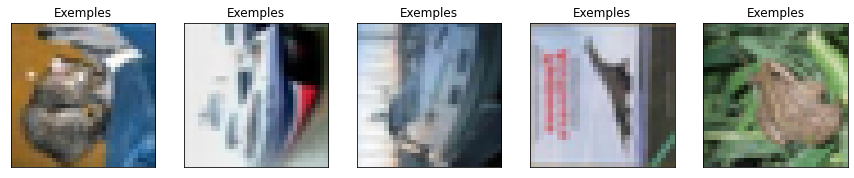

Accuracy: 72.31% 

Epsilon : 0.006604747162022704


100%|██████████| 79/79 [00:00<00:00, 598104.72it/s]


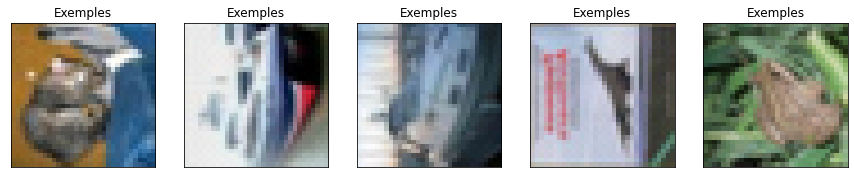

Accuracy: 71.846% 

Epsilon : 0.013209494324045407


100%|██████████| 79/79 [00:00<00:00, 524288.00it/s]


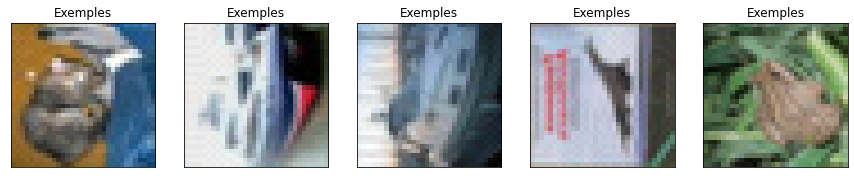

Accuracy: 69.401% 

Epsilon : 0.019814241486068113


100%|██████████| 79/79 [00:00<00:00, 538780.51it/s]


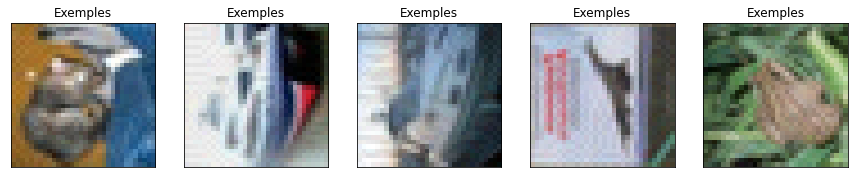

Accuracy: 64.849% 

Epsilon : 0.026418988648090815


100%|██████████| 79/79 [00:00<00:00, 614749.57it/s]


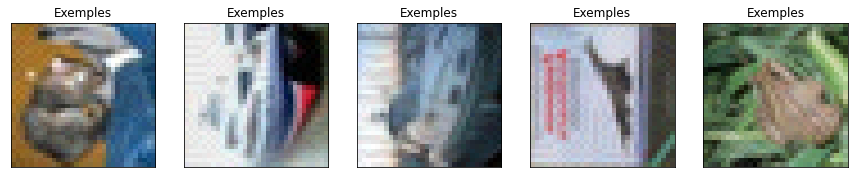

Accuracy: 59.282% 

Epsilon : 0.033023735810113516


100%|██████████| 79/79 [00:00<00:00, 571293.13it/s]


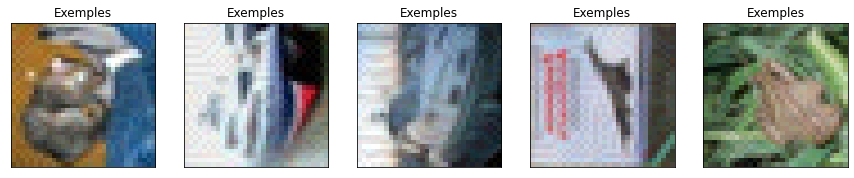

Accuracy: 52.991% 

Epsilon : 0.039628482972136225


100%|██████████| 79/79 [00:00<00:00, 637211.57it/s]


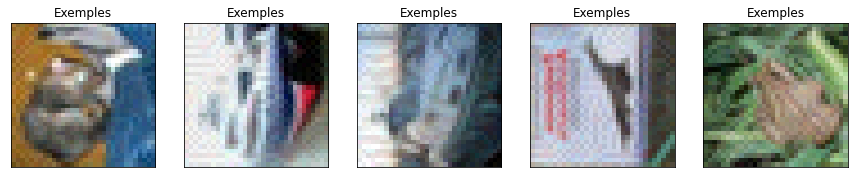

Accuracy: 46.43% 

Epsilon : 0.04623323013415893


100%|██████████| 79/79 [00:00<00:00, 263185.08it/s]


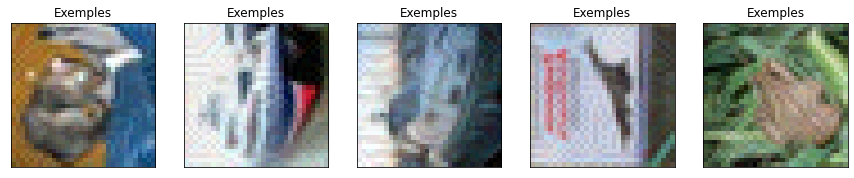

Accuracy: 40.389% 

Epsilon : 0.05283797729618163


100%|██████████| 79/79 [00:00<00:00, 469334.30it/s]


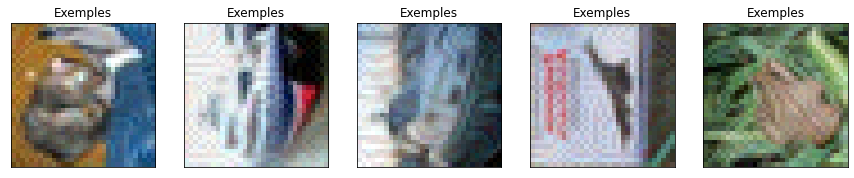

Accuracy: 34.389% 

Epsilon : 0.05944272445820433


100%|██████████| 79/79 [00:00<00:00, 541421.59it/s]


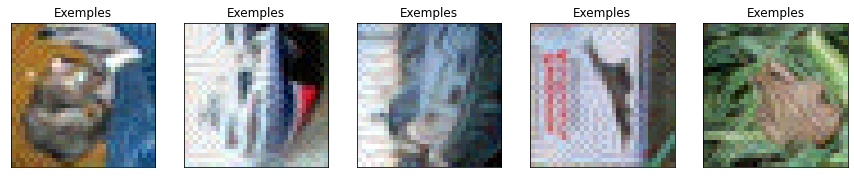

Accuracy: 28.517% 

Epsilon : 0.06604747162022703


100%|██████████| 79/79 [00:00<00:00, 591696.46it/s]


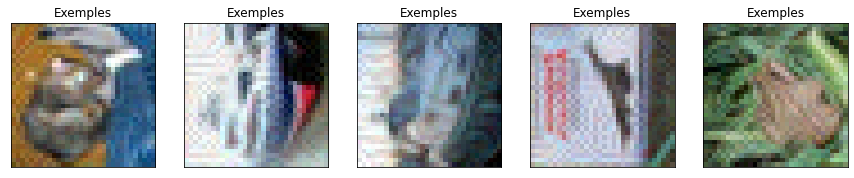

Accuracy: 24.221% 

Epsilon : 0.07265221878224974


100%|██████████| 79/79 [00:00<00:00, 812132.39it/s]


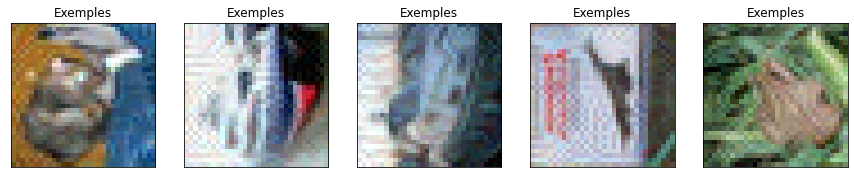

Accuracy: 20.318% 

Epsilon : 0.07925696594427245


100%|██████████| 79/79 [00:00<00:00, 816133.04it/s]


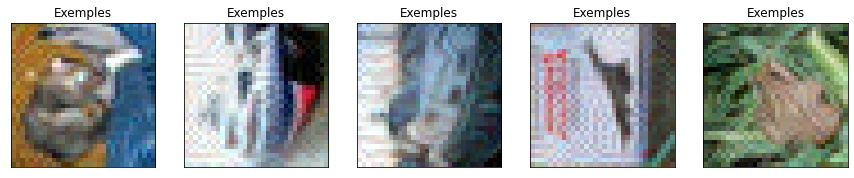

Accuracy: 17.062% 

Epsilon : 0.08586171310629515


100%|██████████| 79/79 [00:00<00:00, 130504.14it/s]


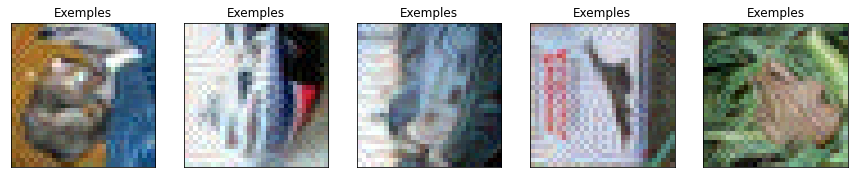

Accuracy: 14.429% 

Epsilon : 0.09246646026831785


100%|██████████| 79/79 [00:00<00:00, 529313.12it/s]


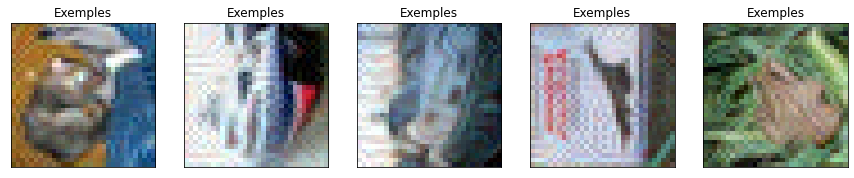

Accuracy: 12.062% 

Epsilon : 0.09907120743034055


100%|██████████| 79/79 [00:00<00:00, 544983.58it/s]


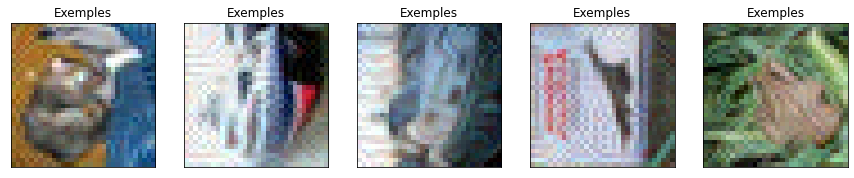

Accuracy: 10.255% 

Epsilon : 0.10567595459236326


100%|██████████| 79/79 [00:00<00:00, 594883.33it/s]


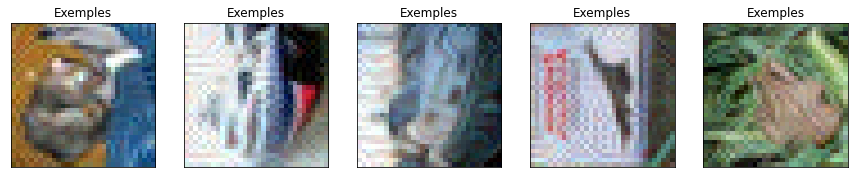

Accuracy: 8.502% 

Epsilon : 0.11228070175438597


100%|██████████| 79/79 [00:00<00:00, 597027.06it/s]


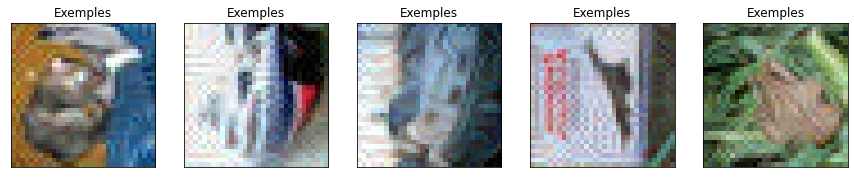

Accuracy: 7.296% 

Epsilon : 0.11888544891640866


100%|██████████| 79/79 [00:00<00:00, 564480.44it/s]


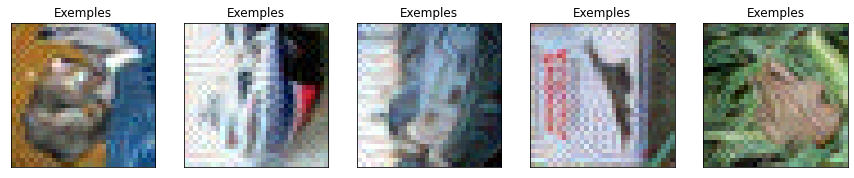

Accuracy: 6.645% 

Epsilon : 0.12549019607843137


100%|██████████| 79/79 [00:00<00:00, 600271.77it/s]


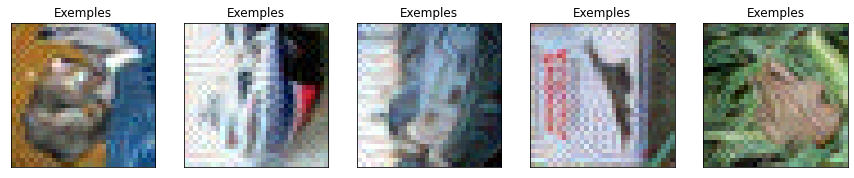

Accuracy: 6.786% 



In [52]:
def add_noise(X):
  X = X + 8/255*torch.randn(*X.shape).to(device)
  return torch.clamp(X,0.,1.)

params = {
    "epsilons" : np.linspace(0,32/255,20),
    "n_iter" : 10,
    "alpha":  3/255, # alpha infini
    "num_exemples": 5,
    "attack" : "PGD",
    "noise": add_noise,
    "denoiser" :None
}

epsilons_adv_w_noise, accuracies_adv_w_noise = pgd_attack_effect_on_accuracy(wide_resnet50_2_adv,device,testloader,params)

Nous allons maintenant comparer les performances du modèle avec ou sans défense et avec ou sans bruit gaussien ajouté à l'image attaquée :

(0.0, 0.13)

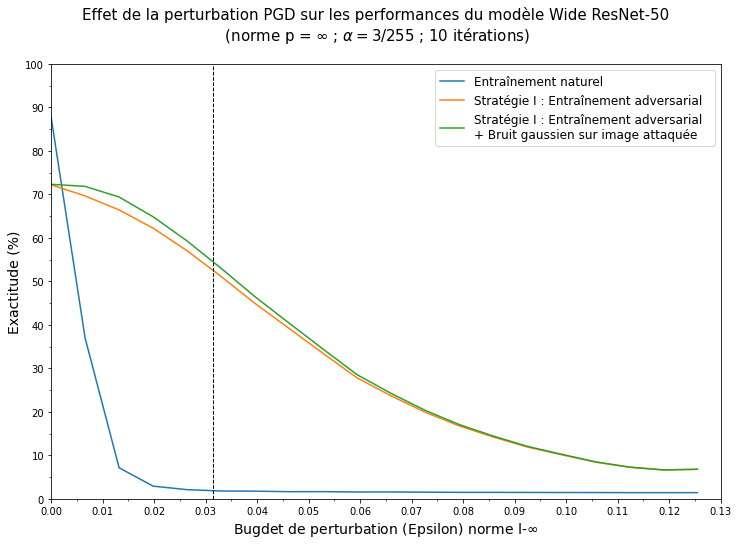

In [50]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
X_Y_LABEL_SIZE = 14
TITLE_SIZE = 15

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epsilons_,accuracy_naturel_wide_Resnet50_2)
ax.plot(epsilons_,accuracy_adv_training_wide_Resnet50_2)
ax.plot(epsilons_,accuracy_adv_training_noise_wide_Resnet50_2)
plt.xlabel(r"Bugdet de perturbation (Epsilon) norme l-$\infty$",fontsize=X_Y_LABEL_SIZE)
plt.ylabel("Exactitude (%)",fontsize=X_Y_LABEL_SIZE)
fig.suptitle('Effet de la perturbation PGD sur les performances du modèle Wide ResNet-50\n'+r' (norme p = $\infty$ ; $\alpha = 3/255$ ; 10 itérations)', fontsize=TITLE_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(0.01))
ax.xaxis.set_minor_locator(MultipleLocator(0.005))

ax.axvline(x=8/255, color='k',lw=1,linestyle="--")

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(["Entraînement naturel",
            "Stratégie I : Entraînement adversarial", 
            "Stratégie I : Entraînement adversarial  \n+ Bruit gaussien sur image attaquée"],loc=1, prop={'size': 12})

plt.ylim([0,100])
plt.xlim([0,0.13])

On remarque que le modèle est légèrement plus robuste avec l'ajout d'un bruit gaussien sur l'image attaquée avant l'inférence.

Ci-dessous nous avons le code (non utilisée ici) pour augmenter le dataset. Nous utilisons le package `albumentations`, un package python permettant d'appliquer un pipeline de transformation.

In [6]:
augmented_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


170499072it [00:10, 16929199.94it/s]                               


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


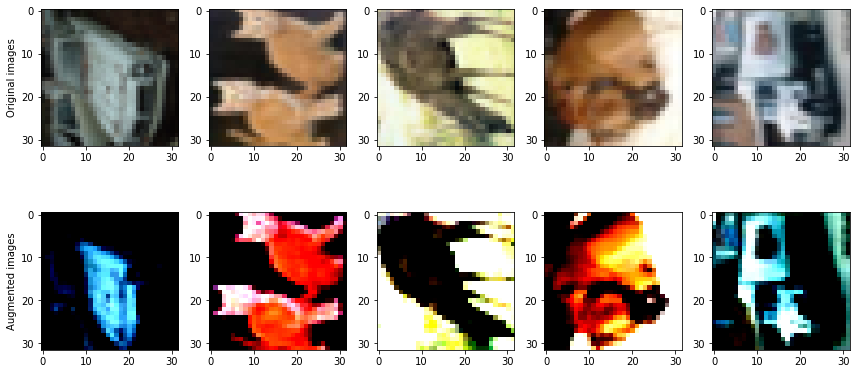

In [7]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root="./data/cifar10", train=True, download=True, transform=None
    ):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label


trainset_augmented = Cifar10Dataset(train=True, transform=augmented_transform)

plot_augmentation(trainset, trainset_augmented, 5)


Ci-dessous nous avons également les implémentations des algorithmes auto-augment et RandAugment proposés directement par le package torchvision. Le package propose un ensemble de politiques pré-entrainés selon le dataset.

In [ ]:
from torchvision import transforms as T

trainset_autoaugment = Cifar10Dataset(
    train=True, transform=T.AutoAugment(T.AutoAugmentPolicy.CIFAR10)
)
trainset_randaugment = Cifar10Dataset(train=True, transform=T.RandAugment)


# Stratégie de défense II : Autoencodeur pour débruiter les images

Afin de faire face aux perturbations contradictoires, des méthodes proposent d’ajouter un bloc de prétraitement en amont du modèle de classification.

Nous nous sommes notamment intéressé à un article (DDSA: A Defense Against Adversarial Attacks Using Deep Denoising Sparse Autoencoder) qui propose d’ajouter un réseau de neurone profond auto-encodeur pour filtrer les attaques et donc les bruits cachés dans l’image attaquée. 

Dans la suite, nous appelons cette architecture d'autoencodeur: DDSA.


L’autoencodeur DDSA agit comme un filtre de bruit et permet d’apprendre une représentation à faible dimension (manifold) qui est robuste aux perturbations. Avec la réduction de dimensionalité, on espère réduire, voire supprimer, les bruits générés par l’attaque.
 

In [9]:
!pip install torchsummary

/home/imaginat0r/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/imaginat0r/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


L'architecture de l'autoencodeur utilisé est une version simplifiée de celle de DDSA, l'architecture est présentée si dessous :

In [14]:
from models import create_ddsa
from torchsummary import summary

# Autoencodeur DDSA
autoencoder = create_ddsa(device)
print(summary(autoencoder, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 30, 30]           3,584
       BatchNorm2d-2          [-1, 128, 30, 30]             256
            Conv2d-3           [-1, 64, 28, 28]          73,792
            Conv2d-4           [-1, 32, 12, 12]          18,464
           Flatten-5                 [-1, 4608]               0
            Linear-6                 [-1, 2048]       9,439,232
            Linear-7                 [-1, 2048]       4,196,352
            Linear-8                 [-1, 4608]       9,441,792
   ConvTranspose2d-9           [-1, 64, 14, 14]          18,496
  ConvTranspose2d-10           [-1, 64, 30, 30]          36,928
  ConvTranspose2d-11            [-1, 3, 32, 32]           1,731
Total params: 23,230,627
Trainable params: 23,230,627
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

/home/imaginat0r/.local/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Les perturbations des attaques adversarial sont conçues pour s’amplifier pendant la phase de forward d’un réseau de neurones. Lors de l'inférence, les couches latentes sont bruitées et certaines activations sont forcées, ce qui provoque des mauvaises prédictions.

Pour tenter de faire face aux effets de ces perturbations, les auteurs de DDSA proposent d’introduire des contraintes de parcimonie sur les couches denses centrales de l'autoencodeur. De cette manière, un neurone n’est actif que pour transmettre des motifs pertinents pour la classification.  Les neurones vont ainsi être inactifs la plupart du temps pour n’extraire que les caractéristiques les pertinentes. Avec cette contrainte, l’objectif est de limiter les fausses activations provoquées par les perturbations.
Nous avons choisi d'utiliser une régularisation avec la norme L1 pour introduire les contraintes de parcimonie sur les couches denses centrales. L'article utilise une approche différente.

Entrainement du modèle de défense avec un autoencodeur sparse (DDSA)


Pour entrainer l’autoencodeur, on lui fourni en entrée des images attaquéees. Comme proposé par les auteurs de DDSA, pour garder une bonne accuracy, on fournit aussi des images d’origine en entrée de l'autoencodeur. 

En sortie, nous utilisons la fonction de coût MSE pour comparer l'image d'origine avec celle reconstruite.
Nous utilisons la même configuration que l'article pour l'entrainement sur CIFAR10:
- Algorithme d'optimisation : RMSProp
- Taille de batch : 32
- Taux d'apprentissage : 0.001

In [40]:
from training import adversarial_training_defense
params = {"epochs" : 100,
    "epsilon" : 8/255, #epsilon infini
    "n_iter" : 7,
    "alpha": 3/255, # alpha infini
    "num_exemples":5,
    "use_FGSM" : True,
    "use_autoencoder" : True,

    "noise_factor" : 0.05,

    "params_autoencoder":{  
        "lr" : 0.001 # 0 pour freeze l'autoencodeur (de-bruitage)   
    },
    "params_model":{
        "lr" : 0.001 # 0 pour freeze le modele
    }
}

wide_resnet50_2_defense = copy.copy(wide_resnet50_2)
adversarial_training_defense(wide_resnet50_2_defense,autoencoder,device,trainloader,testloader,params)

Comme avec la première stratégie de défense, nous allons mesurer l'impact de l'attque PGD-10 sur notre deuxième stratégie de défense (avec autoencodeur DDSA) :

Epsilon : 0.0


100%|██████████| 79/79 [00:00<00:00, 1289299.67it/s]


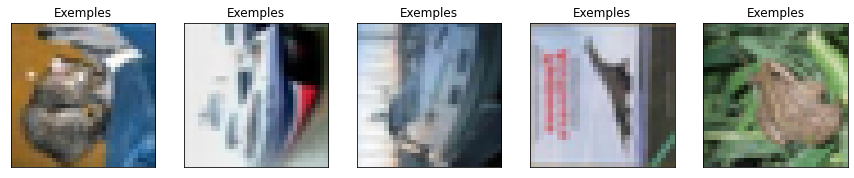

Accuracy: 75.95% 

Epsilon : 0.006604747162022704


100%|██████████| 79/79 [00:00<00:00, 480217.41it/s]


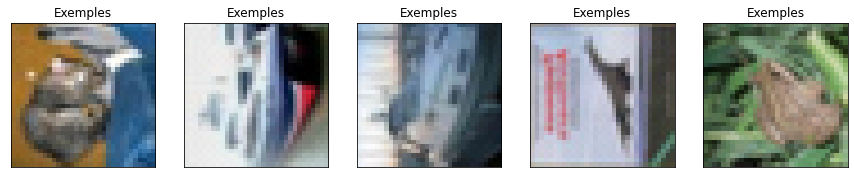

Accuracy: 72.374% 

Epsilon : 0.013209494324045407


100%|██████████| 79/79 [00:00<00:00, 547685.98it/s]


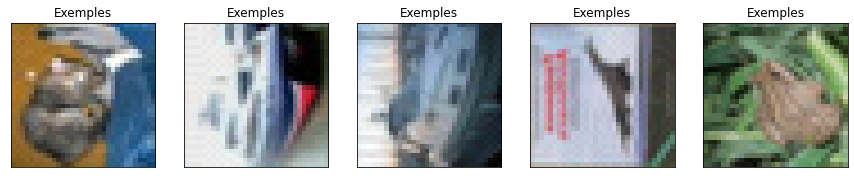

Accuracy: 67.134% 

Epsilon : 0.019814241486068113


100%|██████████| 79/79 [00:00<00:00, 550415.31it/s]


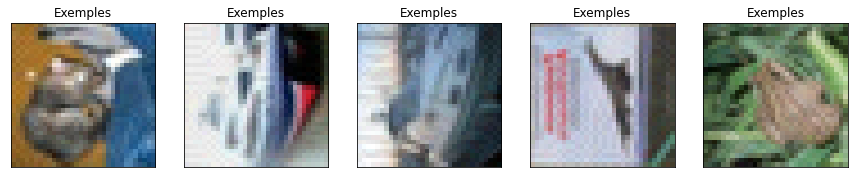

Accuracy: 61.181% 

Epsilon : 0.026418988648090815


100%|██████████| 79/79 [00:00<00:00, 548592.74it/s]


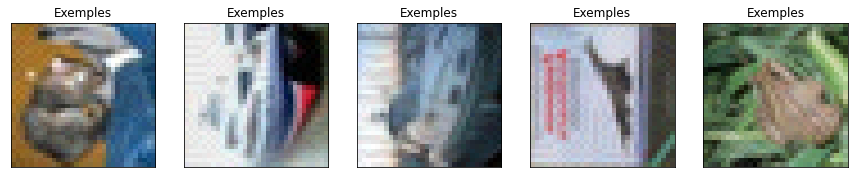

Accuracy: 54.098% 

Epsilon : 0.033023735810113516


100%|██████████| 79/79 [00:00<00:00, 628747.66it/s]


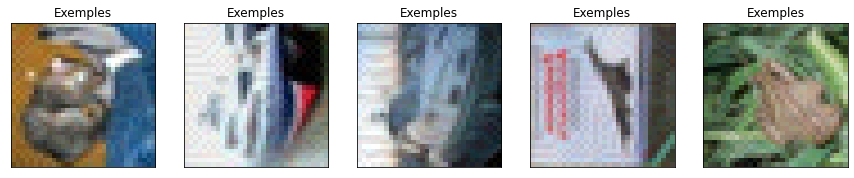

Accuracy: 45.952% 

Epsilon : 0.039628482972136225


100%|██████████| 79/79 [00:00<00:00, 588543.55it/s]


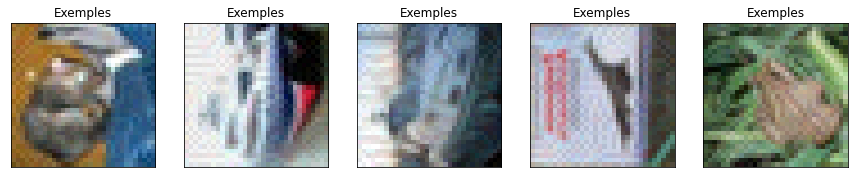

Accuracy: 37.667% 

Epsilon : 0.04623323013415893


100%|██████████| 79/79 [00:00<00:00, 504337.92it/s]


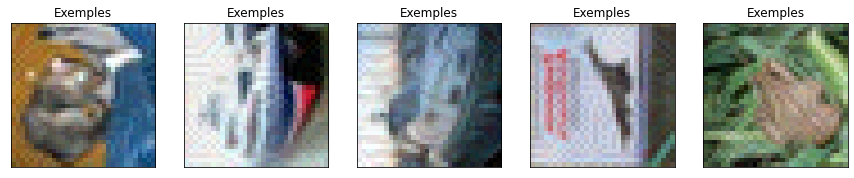

Accuracy: 30.595% 

Epsilon : 0.05283797729618163


100%|██████████| 79/79 [00:00<00:00, 607981.68it/s]


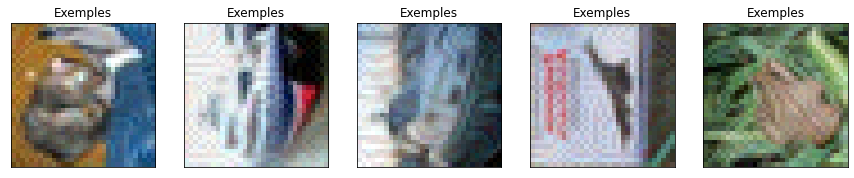

Accuracy: 24.264% 

Epsilon : 0.05944272445820433


100%|██████████| 79/79 [00:00<00:00, 600271.77it/s]


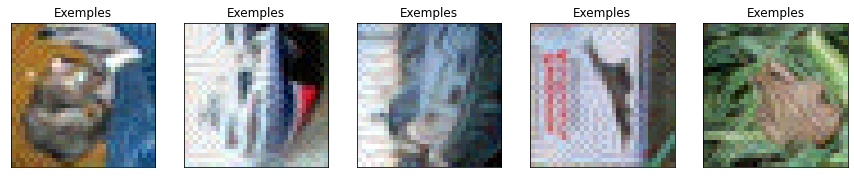

Accuracy: 19.636% 

Epsilon : 0.06604747162022703


100%|██████████| 79/79 [00:00<00:00, 600271.77it/s]


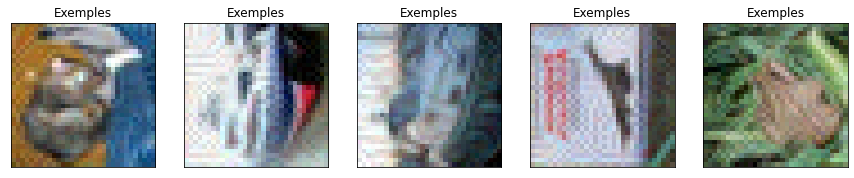

Accuracy: 15.632% 

Epsilon : 0.07265221878224974


100%|██████████| 79/79 [00:00<00:00, 626370.54it/s]


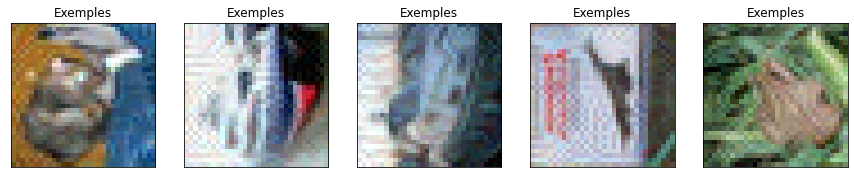

Accuracy: 12.495% 

Epsilon : 0.07925696594427245


100%|██████████| 79/79 [00:00<00:00, 200939.97it/s]


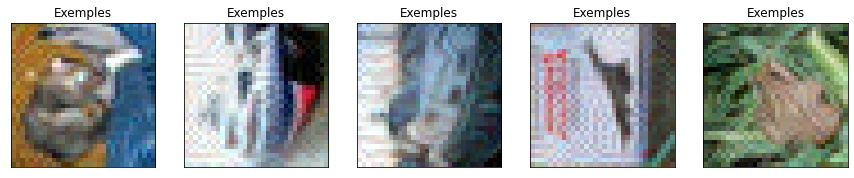

Accuracy: 9.724% 

Epsilon : 0.08586171310629515


100%|██████████| 79/79 [00:00<00:00, 787054.67it/s]


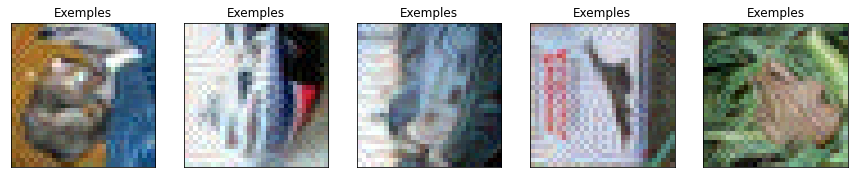

Accuracy: 7.489% 

Epsilon : 0.09246646026831785


100%|██████████| 79/79 [00:00<00:00, 589590.78it/s]


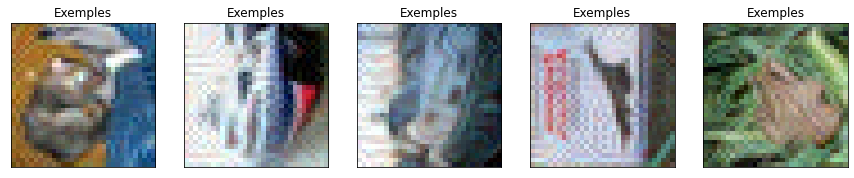

Accuracy: 6.056% 

Epsilon : 0.09907120743034055


100%|██████████| 79/79 [00:00<00:00, 226952.07it/s]


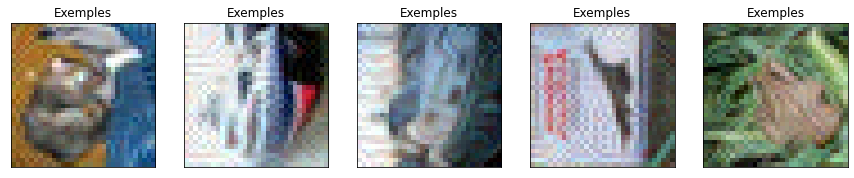

Accuracy: 4.65% 

Epsilon : 0.10567595459236326


100%|██████████| 79/79 [00:00<00:00, 629943.00it/s]


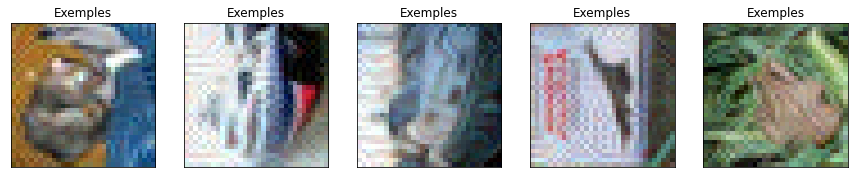

Accuracy: 3.699% 

Epsilon : 0.11228070175438597


100%|██████████| 79/79 [00:00<00:00, 558769.00it/s]


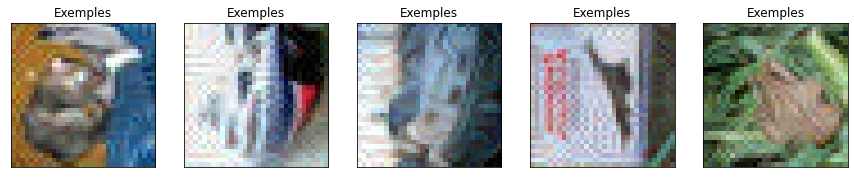

Accuracy: 3.037% 

Epsilon : 0.11888544891640866


100%|██████████| 79/79 [00:00<00:00, 615892.22it/s]


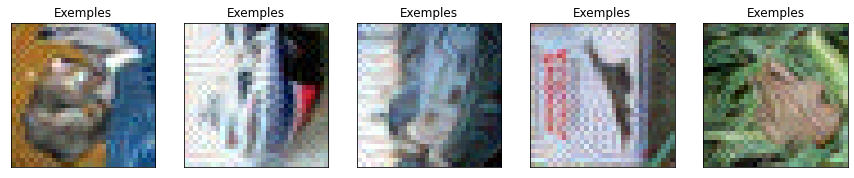

Accuracy: 2.531% 

Epsilon : 0.12549019607843137


100%|██████████| 79/79 [00:00<00:00, 537034.06it/s]


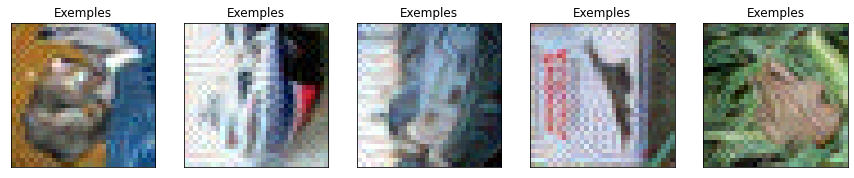

Accuracy: 2.592% 



In [39]:
from evaluate import pgd_attack_effect_on_accuracy

def add_noise(X):
  X = X + 0.03*torch.randn(*X.shape).to(device)
  return torch.clamp(X,0.,1.)


params = {
    "epsilons" : np.linspace(0,32/255,20),
    "n_iter" : 10,
    "alpha":  3/255, # alpha infini
    "num_exemples": 5,
    "denoiser": autoencoder,
    "noise" : None
}

epsilons_defense, accuracies_defense = pgd_attack_effect_on_accuracy(wide_resnet50_2_defense,device,testloader,params)

Comme avec la première stratégie, nous avons également essayé d'ajouter un bruit blanc gaussien sur l'image attaquée avant l'inférence. Il s'agit d'une méthode de défence par l'aléatoire.

Epsilon : 0.0


100%|██████████| 79/79 [00:00<00:00, 1810655.83it/s]


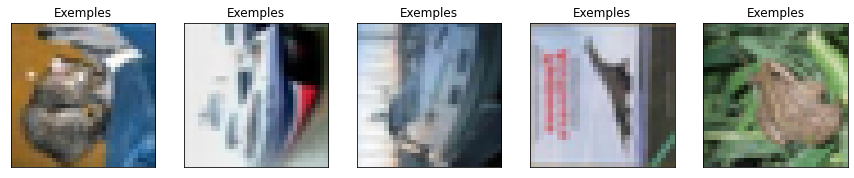

Accuracy: 76.12% 

Epsilon : 0.006604747162022704


100%|██████████| 79/79 [00:00<00:00, 604653.31it/s]


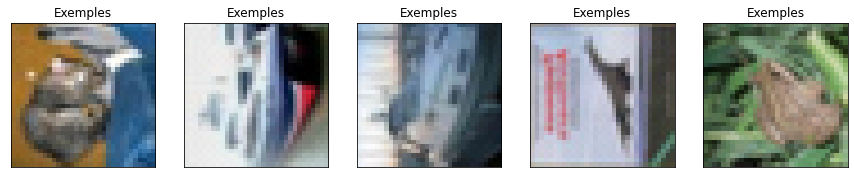

Accuracy: 74.24% 

Epsilon : 0.013209494324045407


100%|██████████| 79/79 [00:00<00:00, 518544.63it/s]


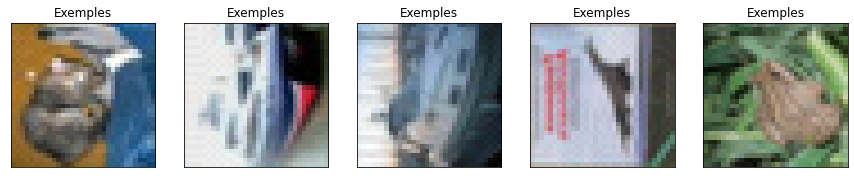

Accuracy: 69.53% 

Epsilon : 0.019814241486068113


100%|██████████| 79/79 [00:00<00:00, 834634.80it/s]


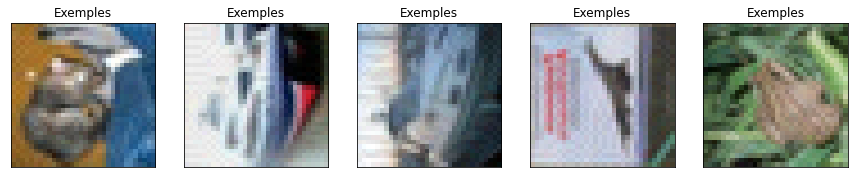

Accuracy: 63.445% 

Epsilon : 0.026418988648090815


100%|██████████| 79/79 [00:00<00:00, 482314.43it/s]


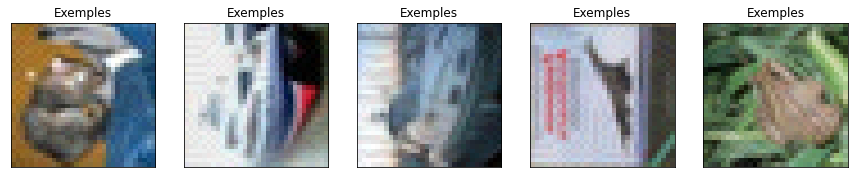

Accuracy: 56.236% 

Epsilon : 0.033023735810113516


100%|██████████| 79/79 [00:00<00:00, 553171.98it/s]


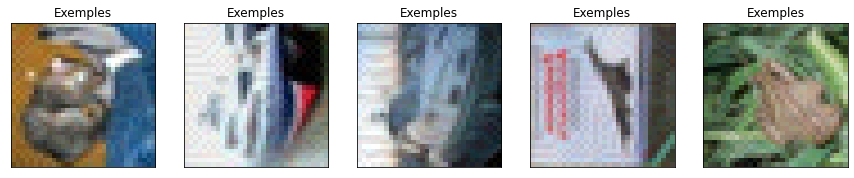

Accuracy: 48.336% 

Epsilon : 0.039628482972136225


100%|██████████| 79/79 [00:00<00:00, 647168.00it/s]


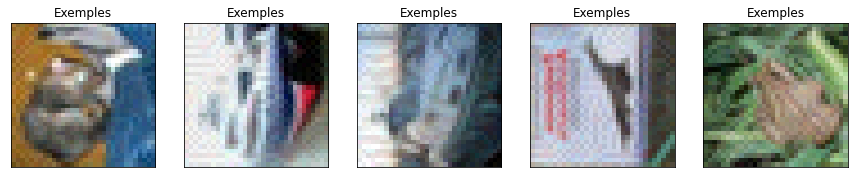

Accuracy: 40.122% 

Epsilon : 0.04623323013415893


100%|██████████| 79/79 [00:00<00:00, 146291.40it/s]


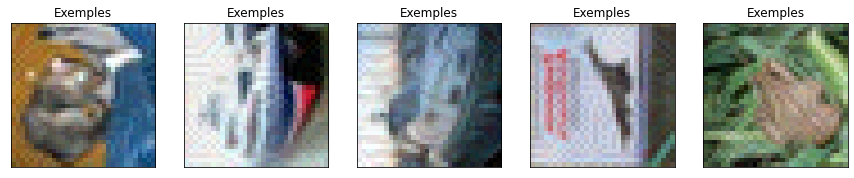

Accuracy: 32.614% 

Epsilon : 0.05283797729618163


100%|██████████| 79/79 [00:00<00:00, 418371.23it/s]


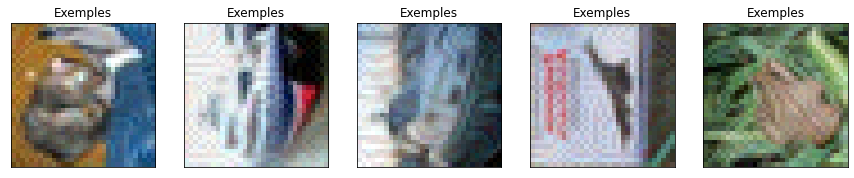

Accuracy: 26.296% 

Epsilon : 0.05944272445820433


100%|██████████| 79/79 [00:00<00:00, 568353.37it/s]


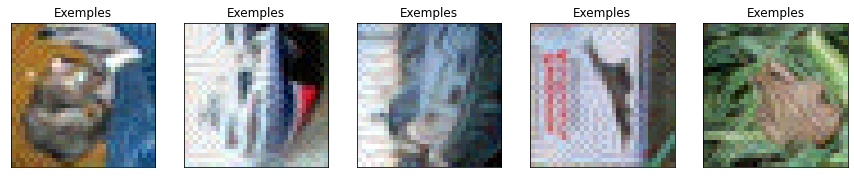

Accuracy: 21.057% 

Epsilon : 0.06604747162022703


100%|██████████| 79/79 [00:00<00:00, 1119425.73it/s]


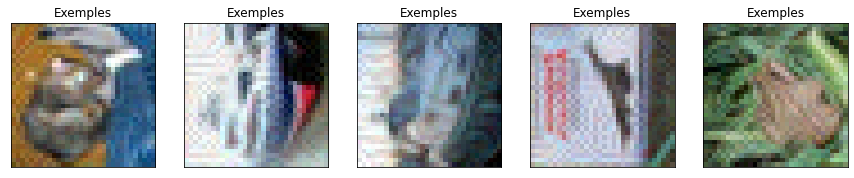

Accuracy: 16.47% 

Epsilon : 0.07265221878224974


100%|██████████| 79/79 [00:00<00:00, 553171.98it/s]


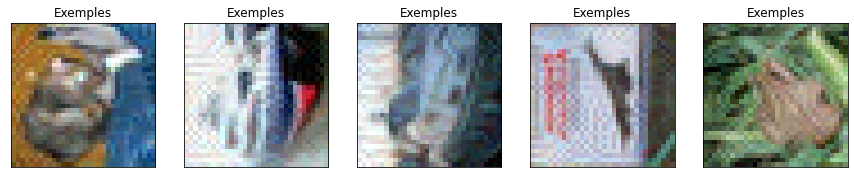

Accuracy: 13.081% 

Epsilon : 0.07925696594427245


100%|██████████| 79/79 [00:00<00:00, 611346.89it/s]


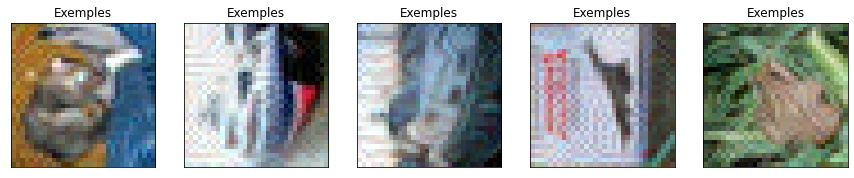

Accuracy: 10.115% 

Epsilon : 0.08586171310629515


100%|██████████| 79/79 [00:00<00:00, 834634.80it/s]


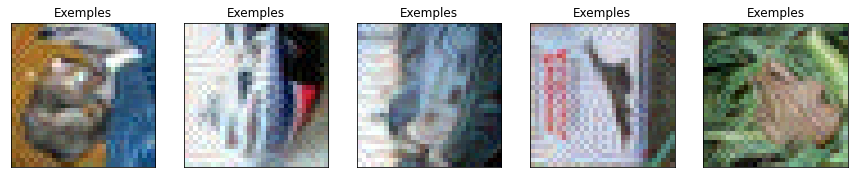

Accuracy: 8.232% 

Epsilon : 0.09246646026831785


100%|██████████| 79/79 [00:00<00:00, 300680.60it/s]


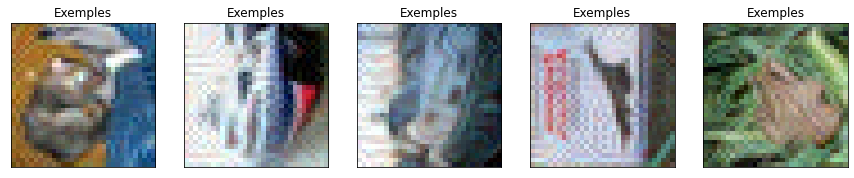

Accuracy: 6.183% 

Epsilon : 0.09907120743034055


100%|██████████| 79/79 [00:00<00:00, 500528.73it/s]


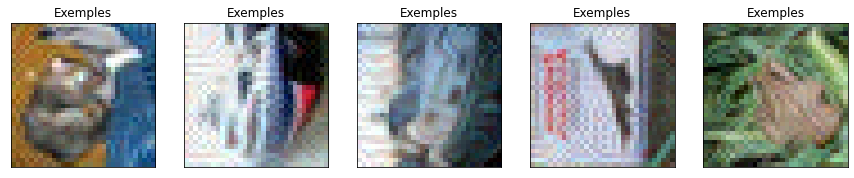

Accuracy: 5.058% 

Epsilon : 0.10567595459236326


100%|██████████| 79/79 [00:00<00:00, 631142.89it/s]


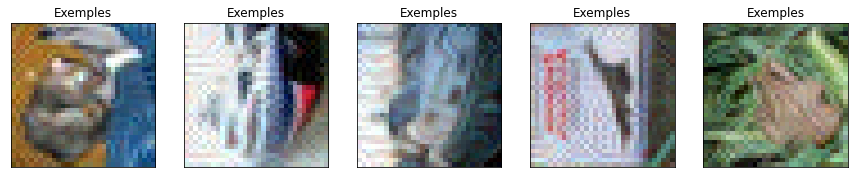

Accuracy: 4.034% 

Epsilon : 0.11228070175438597


100%|██████████| 79/79 [00:00<00:00, 524288.00it/s]


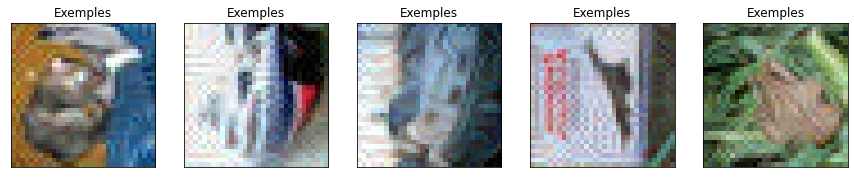

Accuracy: 3.432% 

Epsilon : 0.11888544891640866


100%|██████████| 79/79 [00:00<00:00, 545881.41it/s]


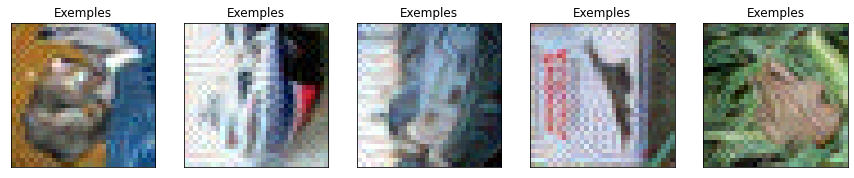

Accuracy: 2.76% 

Epsilon : 0.12549019607843137


100%|██████████| 79/79 [00:00<00:00, 610221.02it/s]


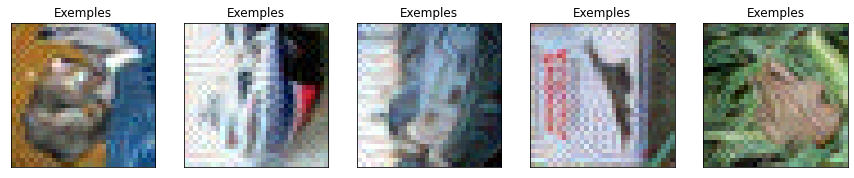

Accuracy: 2.97% 



In [37]:
def add_noise(X):
  X = X + 0.03*torch.randn(*X.shape).to(device)
  return torch.clamp(X,0.,1.)


params = {
    "epsilons" : np.linspace(0,32/255,20),
    "n_iter" : 10,
    "alpha":  3/255, # alpha infini
    "num_exemples": 5,
    "denoiser": autoencoder,
    "noise" : add_noise
}

epsilons_defense, accuracies_defense = pgd_attack_effect_on_accuracy(wide_resnet50_2_defense,device,testloader,params)

Nous allons maintenant comparer les performances du modèle avec ou sans défense et avec ou sans bruit gaussien ajouté à l'image attaquée :

(0.0, 0.13)

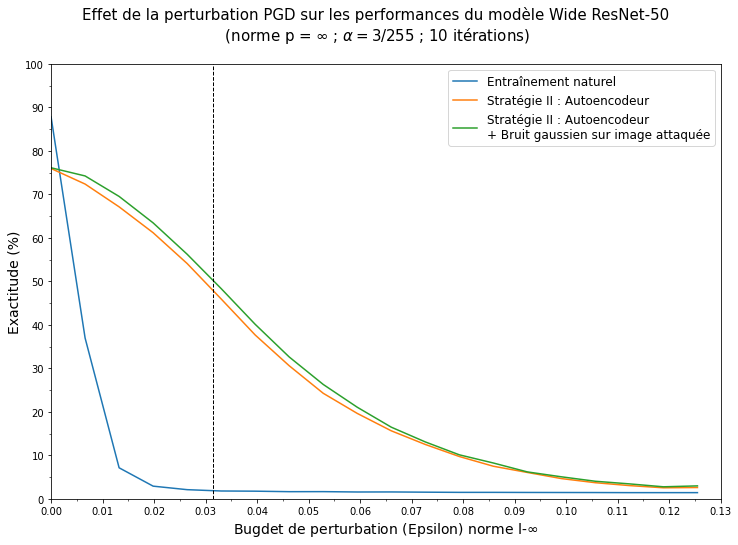

In [51]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
X_Y_LABEL_SIZE = 14
TITLE_SIZE = 15

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epsilons_,accuracy_naturel_wide_Resnet50_2)
ax.plot(epsilons_,accuracies_autoencodeur_wide_Resnet50_2)
ax.plot(epsilons_,accuracies_autoencodeur_noise_wide_Resnet50_2)
plt.xlabel(r"Bugdet de perturbation (Epsilon) norme l-$\infty$",fontsize=X_Y_LABEL_SIZE)
plt.ylabel("Exactitude (%)",fontsize=X_Y_LABEL_SIZE)
fig.suptitle('Effet de la perturbation PGD sur les performances du modèle Wide ResNet-50\n'+r' (norme p = $\infty$ ; $\alpha = 3/255$ ; 10 itérations)', fontsize=TITLE_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(0.01))
ax.xaxis.set_minor_locator(MultipleLocator(0.005))

ax.axvline(x=8/255, color='k',lw=1,linestyle="--")

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(["Entraînement naturel",
            "Stratégie II : Autoencodeur", 
            "Stratégie II : Autoencodeur  \n+ Bruit gaussien sur image attaquée"],loc=1, prop={'size': 12})

plt.ylim([0,100])
plt.xlim([0,0.13])

## Comparaisons

Comparaison des performances des 2 stratégies de défenses face à une attaque PGD-10:
- Stratégie I : Adversarial Training
- Stratégie II : Autoencodeur DDSA (filtrage des bruits sur l'image attaquée)

(0.0, 0.13)

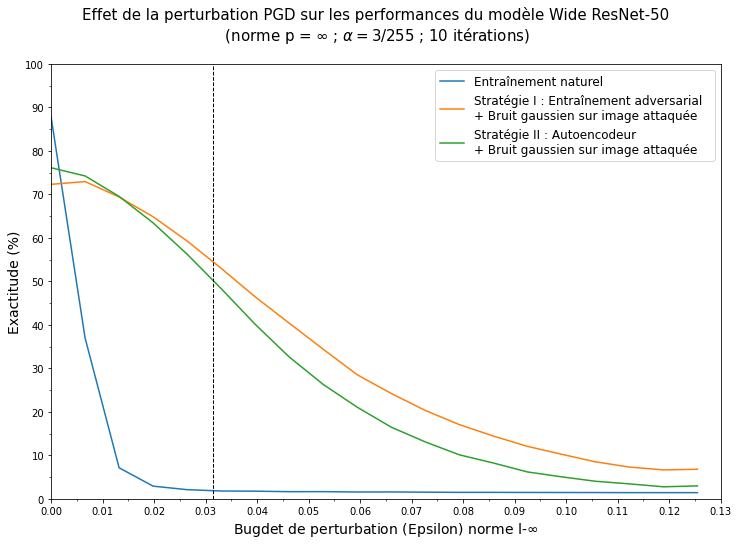

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
X_Y_LABEL_SIZE = 14
TITLE_SIZE = 15

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epsilons_,accuracy_naturel_wide_Resnet50_2)
ax.plot(epsilons_,accuracy_adv_training_noise_wide_Resnet50_2)
ax.plot(epsilons_,accuracies_autoencodeur_noise_wide_Resnet50_2)
plt.xlabel(r"Bugdet de perturbation (Epsilon) norme l-$\infty$",fontsize=X_Y_LABEL_SIZE)
plt.ylabel("Exactitude (%)",fontsize=X_Y_LABEL_SIZE)
fig.suptitle('Effet de la perturbation PGD sur les performances du modèle Wide ResNet-50\n'+r' (norme p = $\infty$ ; $\alpha = 3/255$ ; 10 itérations)', fontsize=TITLE_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(0.01))
ax.xaxis.set_minor_locator(MultipleLocator(0.005))

ax.axvline(x=8/255, color='k',lw=1,linestyle="--")

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(["Entraînement naturel",
            "Stratégie I : Entraînement adversarial  \n+ Bruit gaussien sur image attaquée", 
            "Stratégie II : Autoencodeur  \n+ Bruit gaussien sur image attaquée"],loc=1, prop={'size': 12})

plt.ylim([0,100])
plt.xlim([0,0.13])

On voit que pour un budget de perturbation à 8/255 (norme infinie), les stratégies de défense permettent de maintenir l'accuracy au dessus de 50 %  pour une attaque PGD à 10 itérations.